# **Demographic Population Growth**

- Using 2023 as base, working out the change in population for each demographic group(0-4,5-9 etc), calculating the population change factor from ONS Projections.
- Creating GP List Projections, using the number of patients registered at GP list and population change factor from ONS Projections.
- Comparing and analysing ONS Projections and GP list Projections for each SNEE ICB areas
- Repeating the same for other ONS Scenarios

### **Importing libraries**

In [1]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package
from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

from typing import Dict

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from src.schemas import DataCatalog
import seaborn as sns

# project imports from src
from src.various_methods import PlotCounter
import src.constants as constants

## Module Constants

In [2]:
GP_LIST_OCT_2023 = 'Patients Registered at a GP practice, October 2023' # name of the GP list file
SNEE_SUBICB_CODES = list(constants.SUB_ICB_CODES.keys()) # list of sub-icb codes for SNEE
GP_LIST_AGE_BANDS = [i for i in range(-1,90,5)] + [float('inf')] # -1, 4, 9, ... 84, 89, inf used for pd.cut()
GP_LIST_LABELS = [f"{i+1}-{i+5}" for i in GP_LIST_AGE_BANDS[:-2]] + ["90+"] # 0-4, 5-9, ... 85-89, 90+
OVER_65_LABELS = GP_LIST_LABELS[-6:]

### **Loading the Data catalogue**

In [2]:
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

In [3]:
#Initializing the plotCounter object
plot_counter = PlotCounter(name='demographic_pop_growth')

## **Loading & Preprocessing the Dataset - 'Patients Registered at a GP practice, October 2023'**

In [4]:
#Loading the Dataset to get data on number of patients from GP List
gp_patients_reg_catalog_entry = catalog.get_catalog_entry_by_name(GP_LIST_OCT_2023)
gp_patients_df = gp_patients_reg_catalog_entry.load()
gp_patients_df.head()

/workspaces/PrimaryCareDemandAndCapacity/src/schemas.py:146: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


,PUBLICATION,EXTRACT_DATE,ORG_TYPE,ORG_CODE,ONS_CODE,POSTCODE,SEX,AGE_GROUP_5,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,ALL,ALL,10927943
1,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,0_4,258852
2,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,10_14,300771
3,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,15_19,287618
4,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,20_24,385681


In [5]:
#Checking the values in AGE_GROUP column to match them with the ONS Projections data
print(gp_patients_reg['AGE_GROUP_5'].unique())

['ALL' '0_4' '10_14' '15_19' '20_24' '25_29' '30_34' '35_39' '40_44'
 '45_49' '50_54' '55_59' '5_9' '60_64' '65_69' '70_74' '75_79' '80_84'
 '85_89' '90_94' '95+']


In [6]:
#Replacing AGE_BANDS values to match the ONS_projection data
def rename_gp_list_age_bands_and_columns(df):
    df_ = df.copy()
    # replace these specific cases
    df_['AGE_GROUP_5'] = df_['AGE_GROUP_5'].replace({'90_94':'90+', '95+':'90+'})
    # change _ to - for consistency with ONS projections
    df_['AGE_GROUP_5'] = df_['AGE_GROUP_5'].str.replace('_','-')
    #Renaming the column name to match with ONS projection data
    df_ = df_.rename(columns={'ONS_CODE':'AREA_CODE'})
    return df_
    
def filter_gp_list_and_drop_unused_columns(df):
    df_ = df.copy()
    # Dropping unused columns and rows corrsponding to 'ALL' for AGE_GROUP_5 
    df_ = df_.loc[df_['AGE_GROUP_5']!='ALL']
    # this is due to the 'ALL' row being a sum of all the other rows, the 'SEX' == ALL row are also dropped
    df_ = df_.drop(columns=['PUBLICATION','EXTRACT_DATE','ORG_TYPE','POSTCODE','SEX'])
    # set to ONS area code as index
    df = df_.set_index('AREA_CODE')
    return df_

gp_patients_df = (gp_patients_df
                  .pipe(rename_gp_list_age_bands_and_columns)
                  .pipe(filter_gp_list_and_drop_unused_columns))

gp_patients_df.head()

['0-4' '10-14' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44' '45-49'
 '50-54' '55-59' '5-9' '60-64' '65-69' '70-74' '75-79' '80-84' '85-89'
 '90+']
(311080, 3)


,ORG_CODE,AREA_CODE,AGE_GROUP_5,NUMBER_OF_PATIENTS
1,Y56,E40000003,0-4,258852
2,Y56,E40000003,10-14,300771
3,Y56,E40000003,15-19,287618
4,Y56,E40000003,20-24,385681
5,Y56,E40000003,25-29,535500


### **Filtering the data for Sub-ICB's under SNEE ICB**

In [7]:
def filter_snee_icb_areas(df):
    # copy original df
    df_ = df.copy()
    df_ = df_.loc[df_['ORG_CODE'].isin(SNEE_SUBICB_CODES)]
    return df_

def groupbysum_area_and_age_group_and_rename_ons_codes(df):
    
    df_ = df.copy()
    # Grouping by AREA_CODE and AGE_GROUP_5 and summing the values
    df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()
    # drop the org_code column as not used (ONS area code is the index)
    df_ = df_.drop(columns=['ORG_CODE'])

    df_ = df_.rename(index=constants.ONS_CODES)

    return df_


gp_patients_df = (gp_patients_df
                  .pipe(filter_snee_icb_areas)
                  .pipe(groupbysum_area_and_age_group_and_rename_ons_codes)
                    )

gp_patients_df.head()

NUMBER_OF_PATIENTS
AREA_CODE              AGE_GROUP_5                    
Ipswich & East Suffolk 0-4                       18148
                       10-14                     24231
                       15-19                     23513
                       20-24                     19718
                       25-29                     22975

## **Loading & Preprocessing the Dataset - ONS Population projections**

In [8]:
# just load the first scenario
ons_projection_catalog_entry = catalog.get_scenario_catalog_entry_by_name('ONS Population projections','Principal projection')
ons_projections_df = ons_projection_catalog_entry.load()
ons_projections_df.head()

,AREA_CODE,AREA_NAME,COMPONENT,SEX,AGE_GROUP,2018,2019,2020,2021,2022,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
0,E38000004,NHS Barking and Dagenham CCG,Population,persons,0,3819.0,3539.476,3553.996,3545.026,3503.164,...,3485.017,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681
1,E38000004,NHS Barking and Dagenham CCG,Population,persons,1,3923.0,3841.214,3570.205,3583.060,3571.184,...,3482.414,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301
2,E38000004,NHS Barking and Dagenham CCG,Population,persons,2,4050.0,3912.292,3826.447,3565.341,3575.791,...,3448.544,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800
3,E38000004,NHS Barking and Dagenham CCG,Population,persons,3,3822.0,4036.658,3906.033,3816.546,3563.662,...,3426.572,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447
4,E38000004,NHS Barking and Dagenham CCG,Population,persons,4,3905.0,3805.264,4003.299,3879.217,3788.087,...,3394.732,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373


In [9]:
#Checking the values in AGE_GROUP column to match them with the GP List data
print(ons_projections['AGE_GROUP'].unique())

,AGE_GROUP,2023,2024,2025,2026,2027,2028,2029,2030,2031,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
AREA_CODE,,,,,,,,,,,,,,,,,,,,,
E38000004,0,3469.075,3437.253,3428.219,3418.083,3406.972,3400.285,3399.890,3408.270,3420.751,...,3485.017,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681
E38000004,1,3529.219,3494.651,3462.900,3453.457,3443.087,3431.919,3424.981,3424.216,3431.942,...,3482.414,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301
E38000004,2,3561.177,3519.204,3484.008,3453.543,3443.862,3433.423,3422.364,3415.261,3414.190,...,3448.544,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800
E38000004,3,3572.051,3554.902,3512.813,3478.309,3448.940,3439.117,3428.663,3417.715,3410.517,...,3426.572,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447
E38000004,4,3543.565,3549.867,3530.741,3489.970,3456.359,3428.155,3418.331,3407.972,3397.239,...,3394.732,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373


In [10]:
#Removing values corresponding to 'All ages' in the 'AGE_GROUP' column and dropping unused columns
ons_projections_df = ons_projections.loc[ons_projections['AGE_GROUP']!='All ages'].drop(columns=['AREA_NAME','COMPONENT','SEX','2018','2019','2020','2021','2022']).set_index('AREA_CODE')

ons_projections_df = ons_projections_df.pipe(rename_ons_columns_and_drop_unused)   
ons_projections_df.head()

### **Appending new column having age bands data**

In [11]:
#Specifying the bins and labels for new AGE BANDS columns

def convert_ons_projection_to_5yr_bins(df):
    df_ = df.copy()

    #Converting AGE_GROUP data type to int
    df_['AGE_GROUP'] = df_['AGE_GROUP'].astype(int)

    #Adding the column for Age Bands as 'AGE_GROUP_5'
    df_['AGE_GROUP_5'] = pd.cut(df_['AGE_GROUP'], bins=GP_LIST_AGE_BANDS, labels=GP_LIST_LABELS)
    return df_

ons_projections_df = ons_projections_df.pipe(convert_ons_projection_to_5yr_bins)

ons_projections_df.head()

,AGE_GROUP,2023,2024,2025,2026,2027,2028,2029,2030,2031,...,2035,2036,2037,2038,2039,2040,2041,2042,2043,AGE_GROUP_5
AREA_CODE,,,,,,,,,,,,,,,,,,,,,
E38000004,0,3469.075,3437.253,3428.219,3418.083,3406.972,3400.285,3399.890,3408.270,3420.751,...,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681,0-4
E38000004,1,3529.219,3494.651,3462.900,3453.457,3443.087,3431.919,3424.981,3424.216,3431.942,...,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301,0-4
E38000004,2,3561.177,3519.204,3484.008,3453.543,3443.862,3433.423,3422.364,3415.261,3414.190,...,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800,0-4
E38000004,3,3572.051,3554.902,3512.813,3478.309,3448.940,3439.117,3428.663,3417.715,3410.517,...,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447,0-4
E38000004,4,3543.565,3549.867,3530.741,3489.970,3456.359,3428.155,3418.331,3407.972,3397.239,...,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373,0-4


### **Filtering the data for Sub-ICB's under SNEE ICB**

In [11]:
def filter_ons_to_snee_icb(df):
    df_ = df.copy()
    df_ = df_.loc[df_.index.isin(list(constants.ONS_CODES.keys()))]
    return df_

def ons_groupbysum_area_and_age_group_5(df):
    df_ = df.copy()
    df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()
    df_ = df_.drop(columns=['AGE_GROUP'])
    return df_

ons_projections_df =  (ons_projections_df
                       .pipe(filter_ons_to_snee_icb)
                       .pipe(ons_groupbysum_area_and_age_group_5)
                       .rename(index=constants.ONS_CODES)
                       )
ons_projections_df.head()

/tmp/ipykernel_21098/3095327778.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  snee_ons_projections = ons_projections_df[ons_projections_df.index.isin(required_icb)].groupby(['AREA_CODE', 'AGE_GROUP_5']).sum().drop(columns=['AGE_GROUP'])


2023       2024       2025  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19769.942  19698.373  19604.966   
                       5-9          22791.554  22378.224  21998.493   
                       10-14        25096.067  25016.257  24783.209   
                       15-19        23195.390  23496.655  23897.784   
                       20-24        17350.547  17173.888  17191.096   

                                         2026       2027       2028  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19527.257  19483.805  19446.523   
                       5-9          21529.082  21261.284  21050.186   
                       10-14        24569.717  24249.751  24005.345   
                       15-19        24193.275  24317.998  24191.858   
                       20-24        17520.013  17987.881  18489.898   

                                         2029       2030       2031  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19414.341  19391.237  19381.836   
                       5-9          20983.672  20896.032  20825.220   
                       10-14        23584.788  23208.398  22734.049   
                       15-19        24085.124  23861.980  23735.101   
                       20-24        18808.913  19207.344  19504.800   

                                         2032  ...       2034       2035  \
AREA_CODE              AGE_GROUP_5             ...                         
Ipswich & East Suffolk 0-4          19393.561  ...  19490.582  19575.604   
                       5-9          20787.879  ...  20730.435  20713.191   
                       10-14        22463.455  ...  22183.313  22097.687   
                       15-19        23447.633  ...  22773.296  22376.525   
                       20-24        19722.030  ...  19789.355  19742.953   

                                         2036       2037       2038  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19686.005  19821.500  19978.838   
                       5-9          20709.948  20728.187  20771.506   
                       10-14        22028.982  21994.096  21965.440   
                       15-19        21998.140  21733.338  21566.061   
                       20-24        19656.351  19404.588  19195.243   

                                         2039       2040       2041  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          20152.670  20332.876  20507.740   
                       5-9          20840.531  20934.368  21054.439   
                       10-14        21942.197  21928.291  21928.799   
                       15-19        21499.806  21422.362  21367.768   
                       20-24        18928.754  18660.077  18324.626   

                                         2042       2043  
AREA_CODE              AGE_GROUP_5                        
Ipswich & East Suffolk 0-4          20666.628  20800.504  
                       5-9          21200.433  21369.098  
                       10-14        21951.560  22000.292  
                       15-19        21336.679  21311.481  
                       20-24        18080.678  17917.411  

[5 rows x 21 columns]

### **Calculating the population change factor for each year keeping 2023 as baseline**

In [12]:
pop_baseline = snee_ons_projections['2023']
snee_factors_ons_projections = snee_ons_projections.div(pop_baseline, axis=0).round(5)

### Pipeline of ONS scenarios

In [13]:
dict_snee_ons_factors = snee_factors_ons_projections.to_dict(orient='index')

## **Creating GP Projections dataframes**
**- by Multiplying each year's projection factor from ONS Projections with the number of patients from GP list**

In [14]:
# create a dict containing the projections for each scenario in the ONS projections
gp_list_projections:Dict[str,pd.DataFrame] = {}
gp_list_2023:pd.Series = gp_patients_df['NUMBER_OF_PATIENTS'].copy()
for scenario_name, scenario_df in growth_factors.items():
    # multiply the scenario growth factors by the GP list patients
    gp_list_projections[scenario_name] = scenario_df.multiply(gp_list_2023,axis=0).round(0).astype(int)

# show the principal projection
snee_gp_projections:pd.DataFrame = gp_list_projections['Principal projection'].copy()

snee_gp_projections.head()

2023   2024   2025   2026   2027   2028  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4          18148  18082  17997  17925  17885  17851   
                       5-9          22318  21913  21541  21082  20820  20613   
                       10-14        24231  24154  23929  23723  23414  23178   
                       15-19        23513  23818  24225  24525  24651  24523   
                       20-24        19718  19517  19537  19911  20442  21013   

                                     2029   2030   2031   2032  ...   2034  \
AREA_CODE              AGE_GROUP_5                              ...          
Ipswich & East Suffolk 0-4          17822  17800  17792  17802  ...  17892   
                       5-9          20548  20462  20393  20356  ...  20300   
                       10-14        22772  22408  21950  21689  ...  21419   
                       15-19        24415  24189  24060  23769  ...  23085   
                       20-24        21375  21828  22166  22413  ...  22490   

                                     2035   2036   2037   2038   2039   2040  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4          17970  18071  18195  18340  18499  18665   
                       5-9          20283  20280  20298  20340  20408  20499   
                       10-14        21336  21270  21236  21208  21186  21172   
                       15-19        22683  22299  22031  21861  21794  21716   
                       20-24        22437  22339  22052  21814  21512  21206   

                                     2041   2042   2043  
AREA_CODE              AGE_GROUP_5                       
Ipswich & East Suffolk 0-4          18825  18971  19094  
                       5-9          20617  20760  20925  
                       10-14        21173  21195  21242  
                       15-19        21660  21629  21603  
                       20-24        20825  20548  20362  

[5 rows x 21 columns]

In [15]:
gp_list_2023:pd.Series = gp_patients_df['NUMBER_OF_PATIENTS'].copy()


In [16]:
#visualise snee_gp_projections as population pyramid
snee_pop_pyramid_df = snee_gp_projections.reset_index().rename(columns={'AREA_CODE':'Sub-ICB','AGE_GROUP_5':'Age Band'})
gp_list_total_df = snee_pop_pyramid_df.groupby('Sub-ICB').sum(numeric_only=True).T
gp_list_total_df.index.name = 'Year'
gp_list_total_df

Sub-ICB,Ipswich & East Suffolk,North East Essex,West Suffolk
Year,,,
2023,415239,372568,276105
2024,416539,375839,277177
2025,417744,378953,278242
2026,418938,382019,279274
2027,420106,384982,280185
2028,421230,387817,281080
2029,422297,390532,281875
2030,423300,393140,282598
2031,424319,395685,283361


## Plots
### Population growth scenarios

AREA_CODE               AGE_GROUP_5
Ipswich & East Suffolk  0-4            18148
                        10-14          24231
                        15-19          23513
                        20-24          19718
                        25-29          22975
                        30-34          26197
                        35-39          27046
                        40-44          26757
                        45-49          24675
                        5-9            22318
                        50-54          28246
                        55-59          29474
                        60-64          27504
                        65-69          24094
                        70-74          22465
                        75-79          21514
                        80-84          13002
                        85-89           8418
                        90+             4944
North East Essex        0-4            17141
                        10-14          21753
                   

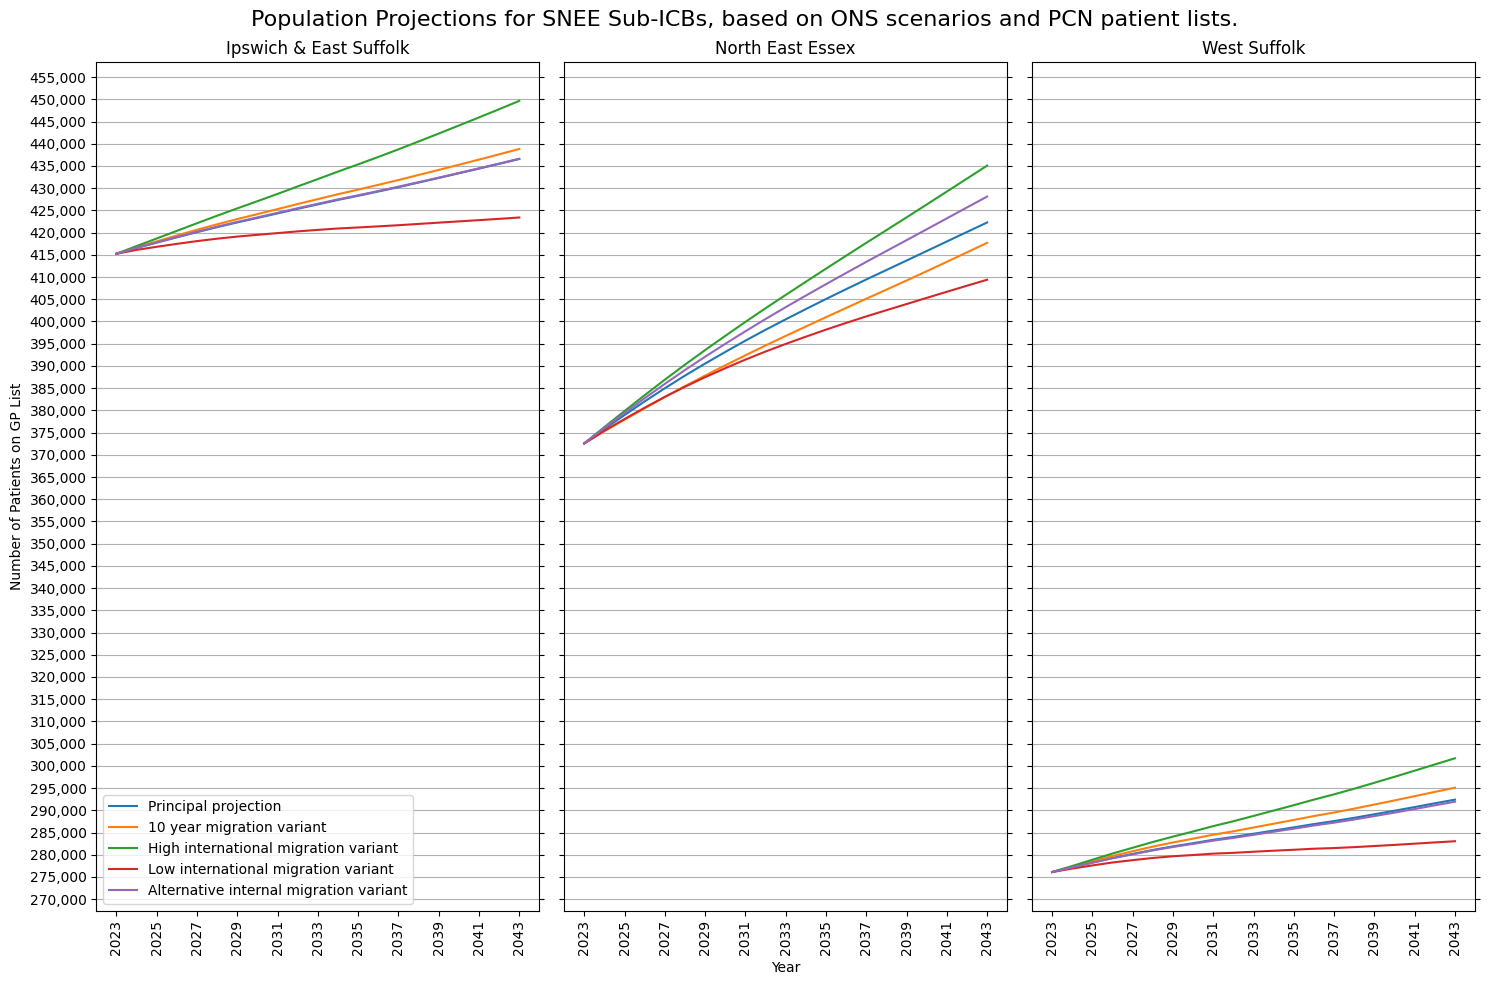

In [ ]:

fig, axes = plt.subplots(1,3,figsize=(15,10), sharey=True)
fig.suptitle("Population Projections for SNEE Sub-ICBs, based on ONS scenarios and PCN patient lists.", fontsize=16)
scenario_count = 0
for scenario_name, scenario_df in gp_list_projections.items():
    scenario_total_df_ = scenario_df.copy().reset_index().rename(columns={'AREA_CODE':'Sub-ICB','AGE_GROUP_5':'Age Band'})
    scenario_total_df_ = scenario_total_df_.groupby('Sub-ICB').sum(numeric_only=True).T
    scenario_total_df_.index.name = 'Year'

    
    for i, sub_icb in enumerate(scenario_total_df_.columns):
        axes[i].yaxis.set_major_locator(ticker.MultipleLocator(5000))
        # set y format to show thousands
        axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        # show y ticks
        axes[i].yaxis.set_ticks_position('both')
        axes[i].plot(scenario_total_df_[sub_icb], label=scenario_name)
        # set ticks on y axis to 10000 per tick
        axes[i].set_title(sub_icb)
        # add y gridlines
        axes[i].grid(axis='y')

        if i == 0:
            axes[i].set_ylabel('Number of Patients on GP List')
        if i == 1:
            axes[i].set_xlabel('Year')

        # rotate the x-axis labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)
    scenario_count += 1

axes[0].legend()
plt.tight_layout()
plt.show()

### Over 65's Scenarios

In [24]:
ten_percents

{}

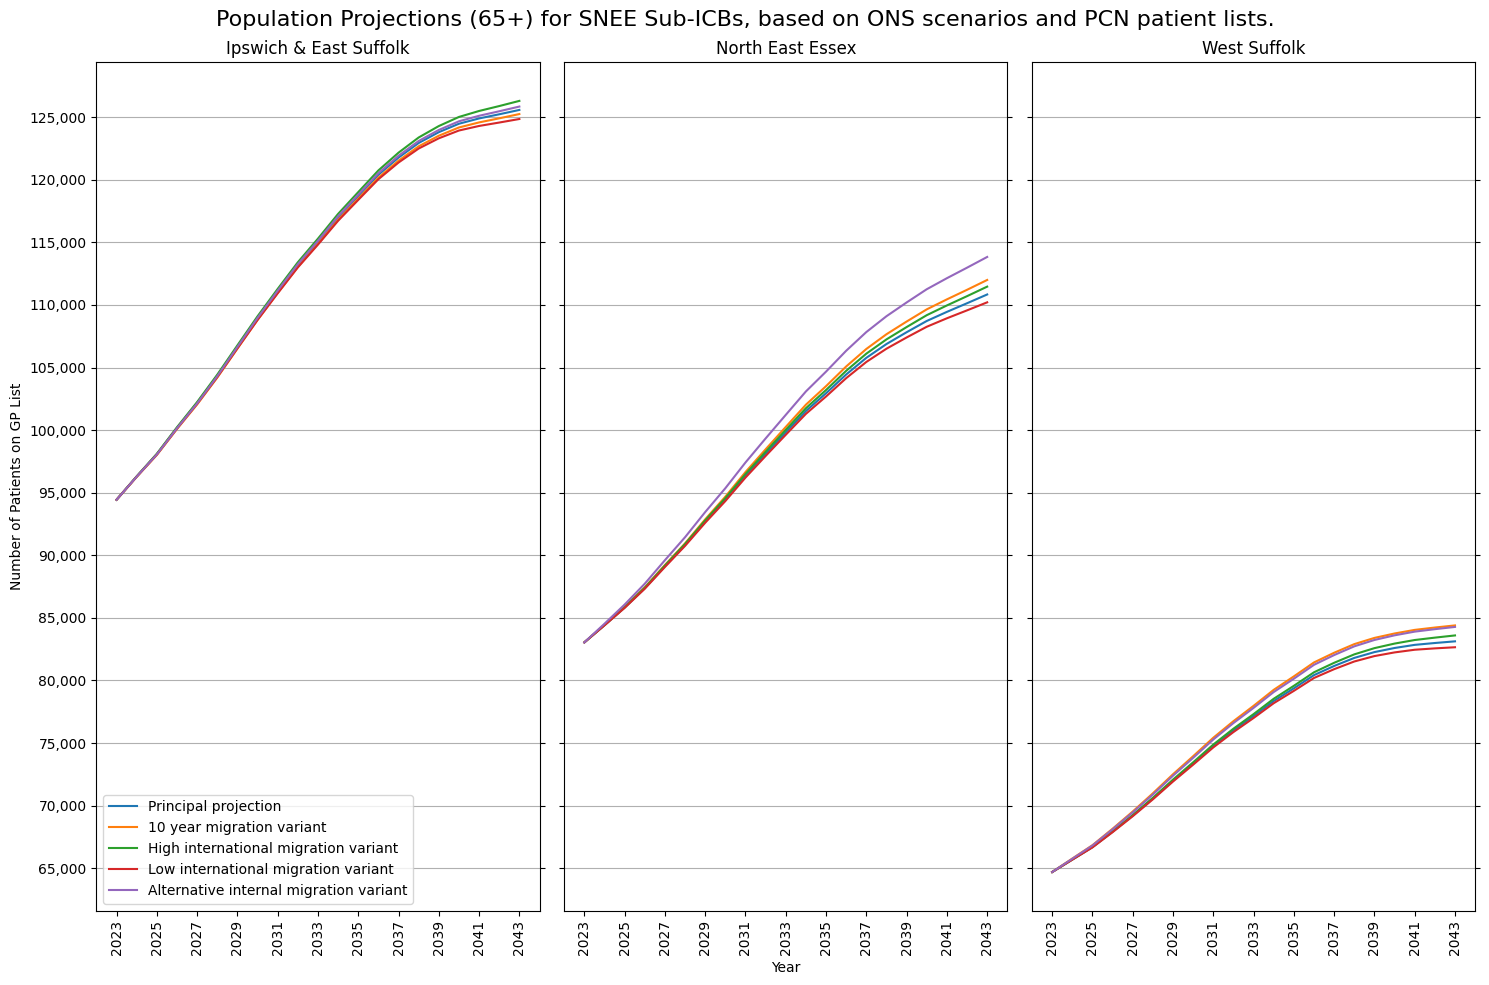

In [25]:

fig, axes = plt.subplots(1,3,figsize=(15,10), sharey=True)
fig.suptitle("Population Projections (65+) for SNEE Sub-ICBs, based on ONS scenarios and PCN patient lists.", fontsize=16)
scenario_count = 0
for scenario_name, scenario_df in gp_list_projections.items():
    scenario_total_df_ = scenario_df.copy().reset_index().rename(columns={'AREA_CODE':'Sub-ICB','AGE_GROUP_5':'Age Band'})
    scenario_total_df_ = scenario_total_df_.loc[scenario_total_df_['Age Band'].isin(OVER_65_LABELS)]
    
    scenario_total_df_ = scenario_total_df_.groupby('Sub-ICB').sum(numeric_only=True).T
    scenario_total_df_.index.name = 'Year'

    ten_percents = {}
    twenty_percents = {}
    # if scenario_name == 'Principal projection':
    #     for column in scenario_total_df_.columns:
    #         ten_percents[column] = scenario_total_df_[column].iloc[0] * 1.1
    #         twenty_percents[column] = scenario_total_df_[column].iloc[0] * 1.2
        


    
    for i, sub_icb in enumerate(scenario_total_df_.columns):
        axes[i].yaxis.set_major_locator(ticker.MultipleLocator(5000))
        # set y format to show thousands
        axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        # show y ticks
        axes[i].yaxis.set_ticks_position('both')
        axes[i].plot(scenario_total_df_[sub_icb], label=scenario_name)
        # set ticks on y axis to 10000 per tick
        axes[i].set_title(sub_icb)
        
        # add y gridlines
        axes[i].grid(axis='y')

        if i == 0:
            axes[i].set_ylabel('Number of Patients on GP List')
            # axes[i].axhline(y=ten_percents[sub_icb], color='r', linestyle='--', label='+10% (2023)')
        if i == 1:
            axes[i].set_xlabel('Year')

        # rotate the x-axis labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)
    scenario_count += 1

axes[0].legend()
plt.tight_layout()
plt.show()

### **Lineplot Barplots and Pyramid plot between 2023: ONS Projections VS GP list Projections**

- We can see that ONS-Projections are close with GP-Patients list at older age groups for all 3 sub icb's
- For all 3 sub-icb's between age 20-24 to 45-49 the ONS-Projections are significantly lower that GP Patients list.
- For West Suffolk the GP Patients list are higher than ONS Projections except when the population is in age bands 0-4 and 90+

In [ ]:
#Function to plot Barplot for each Sub Icb under SNEE separately
def bar_plots_pyramids(df_:pd.DataFrame, year:int)->None:
    fig, axes =  plt.subplots(3, figsize=(15,15))

    for index, area in enumerate(df_.AREA_CODE.unique()):
        sub_df = df_.loc[df_['AREA_CODE']==area].copy()
        sns.barplot(sub_df, x='AGE_GROUP_5', y=str(year), hue='source', ax=axes[index], width=0.6)
        axes[index].set_title(f"ONS Projection and GP Projection demographics: {area}, {year}")
        axes[index].set_xlabel(f"Age group")
        axes[index].set_ylabel(f"Population (persons)")
        plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


for i in [2023]:
    bar_plots_pyramids(combined_df_2,i)

plt.show()

### **Lineplot Barplots and Pyramid plot between 2033: ONS Projections VS GP list Projections**

In [ ]:
#Plotting the pyramid plot
plt.figure(figsize=(15,6))
plt.xlabel('Population (persons)')
plt.ylabel('Age Group')
plt.title('GP(left) and ONS(right) Projections for 2033 - (SNEE ICB)')
#Creating a negative 2033 GP Projection column for plotting on pyramid
combined_df['N-2033-GP_Projection'] = -combined_df['2033-GP_Projection']
sns.barplot(x='2033-ONS_Projection', y='AGE_GROUP_5',hue='AREA_CODE', data=combined_df)
sns.barplot(x='N-2033-GP_Projection', y='AGE_GROUP_5',hue='AREA_CODE', data=combined_df, palette=colors)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


#Plotting the lineplot
plt.figure(figsize=(15,6))
plt.xlabel('Age Group')
plt.ylabel('Population (persons)')
plt.title('GP(:) and ONS(-) Projections for 2033 - (SNEE ICB)')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-ONS_Projection', hue='AREA_CODE')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-GP_Projection', hue='AREA_CODE', linestyle=':')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

* For North East Essex the GP Projections are very close to the ONS Projections from age group 0-4 to 20-24 and varies after than until almost collides from age group 65-69 until 90+
* For Ipswich and East Suffolk the GP projections are slightly lower than the ONS Projections from age group 50-54 until 90+
* For West Suffolk the GP Projections are higher than ONS Projections except when the population is in age bands 0-4 and 90+

In [ ]:
#Function to plot Barplot for each Sub Icb under SNEE separately
def bar_plots_pyramids(df_:pd.DataFrame, year:int)->None:
    fig, axes =  plt.subplots(3, figsize=(15,15))

    for index, area in enumerate(df_.AREA_CODE.unique()):
        sub_df = df_.loc[df_['AREA_CODE']==area].copy()
        sns.barplot(sub_df, x='AGE_GROUP_5', y=str(year), hue='source', ax=axes[index], width=0.6)
        axes[index].set_title(f"ONS Projection and GP Projection demographics: {area}, {year}")
        axes[index].set_xlabel(f"Age group")
        axes[index].set_ylabel(f"Population (persons)")
        plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

for i in [2033]:
    bar_plots_pyramids(combined_df_2,i)

plt.show()

### **Lineplot Barplots and Pyramid plot between 2023 and 2033 GP list Projections**

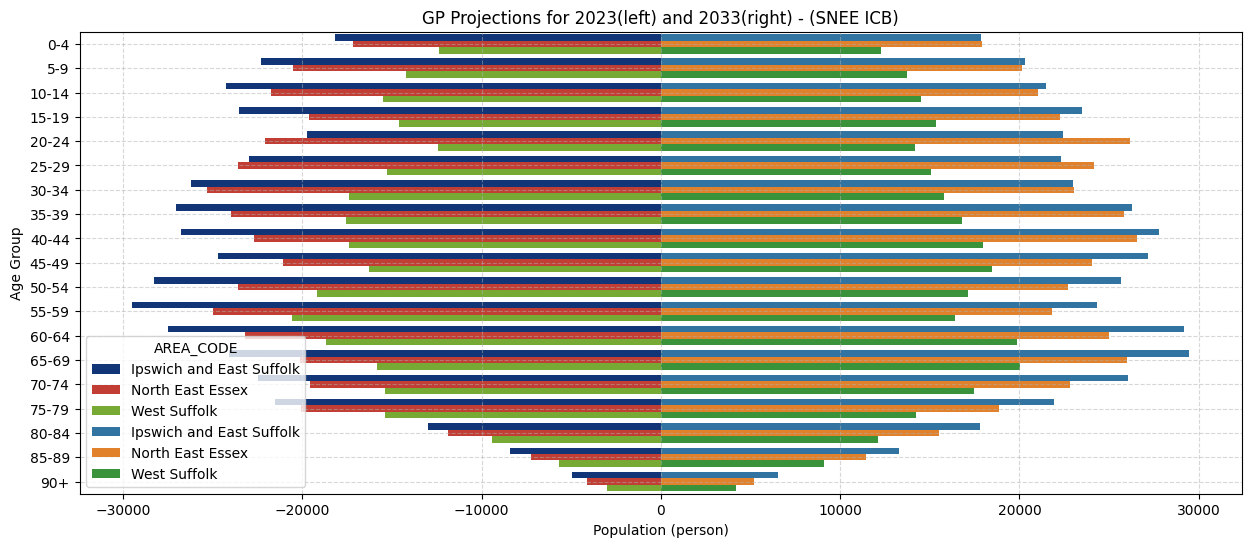

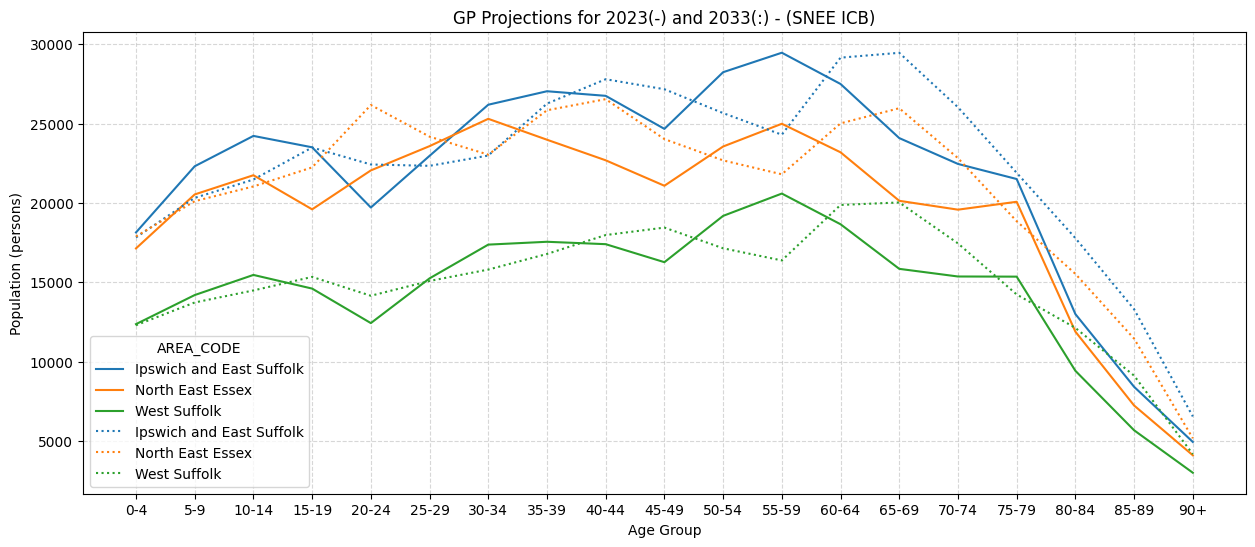

In [ ]:
#Plotting the pyramid plot
plt.figure(figsize=(15,6))
plt.xlabel('Population (person)')
plt.ylabel('Age Group')
plt.title('GP Projections for 2023(left) and 2033(right) - (SNEE ICB)')
sns.barplot(x='N-2023-GP_Projection', y='AGE_GROUP_5',hue='AREA_CODE', data=combined_df, palette=colors)
sns.barplot(x='2033-GP_Projection', y='AGE_GROUP_5',hue='AREA_CODE', data=combined_df)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


#Plotting the linplot
plt.figure(figsize=(15,6))
plt.xlabel('Age Group')
plt.ylabel('Population (persons)')
plt.title('GP Projections for 2023(-) and 2033(:) - (SNEE ICB)')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2023-GP_Projection', hue='AREA_CODE')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-GP_Projection', hue='AREA_CODE', linestyle=':')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

* The peak for GP_Projections 2033 in West suffolk and Ipswich & East Suffolk is at 65-69 and the peak for year 2023 is at 55-59, which is expected as we are comparing 10 years difference in projections
* The overall population projection is pointing towards the population getting older and confined to older age bands

### **Lineplot Barplots and Pyramid plot between 2023 and 2033 ONS Projections**

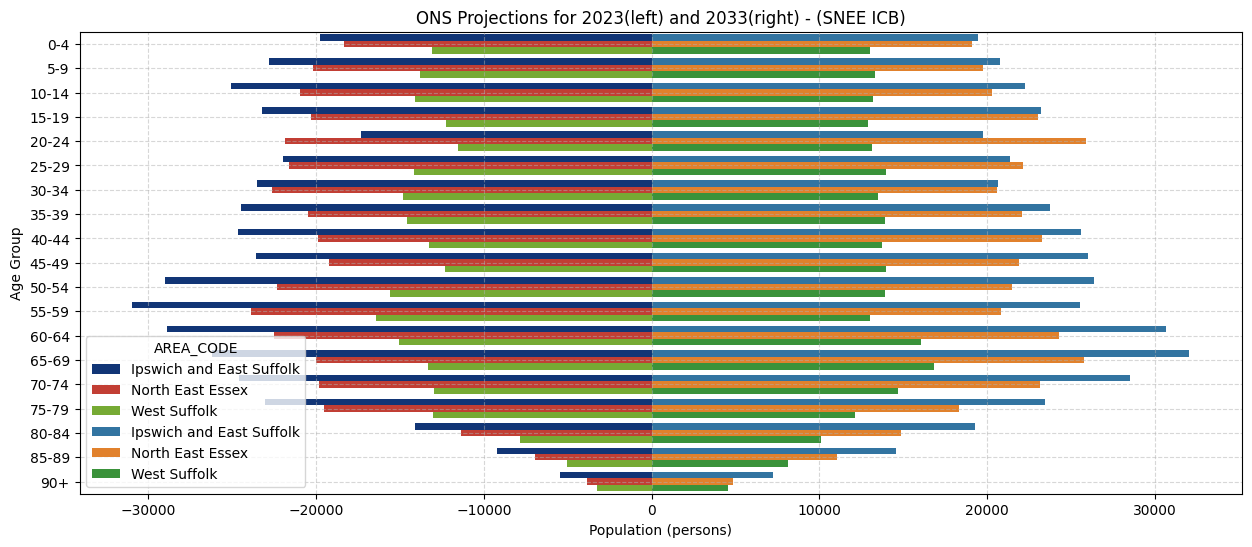

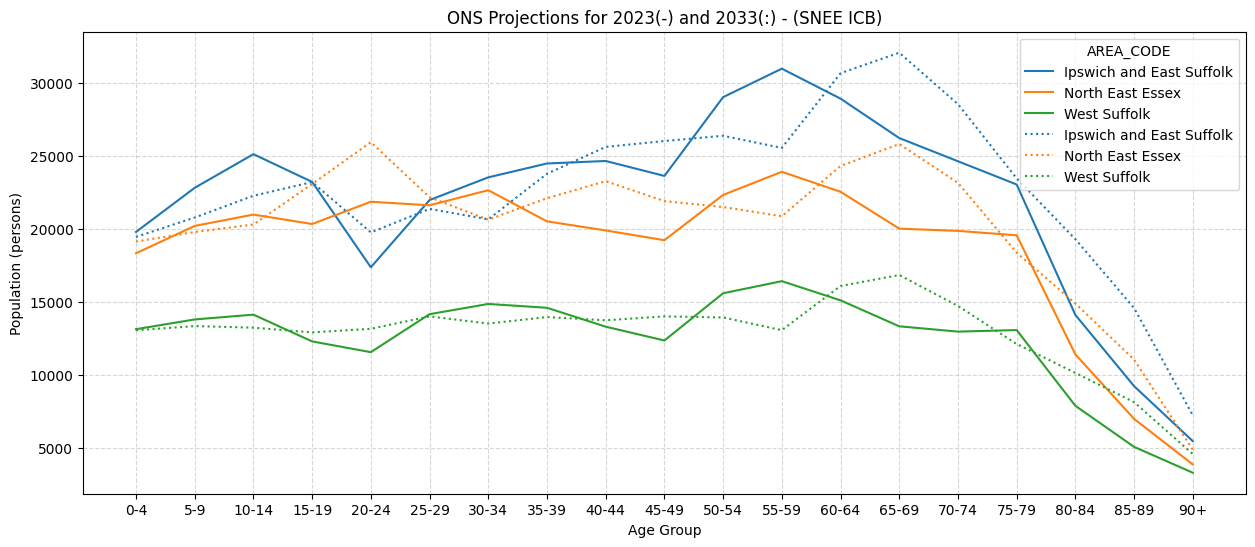

In [22]:
#Plotting the Pyramid plot
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Population (persons)')
plt.ylabel('Age Group')
plt.title('ONS Projections for 2023(left) and 2033(right) - (SNEE ICB)')
combined_df['N-2023-ONS_Projection'] = -combined_df['2023-ONS_Projection']
sns.barplot(x='N-2023-ONS_Projection', y='AGE_GROUP_5', hue='AREA_CODE', data=combined_df, palette=colors)
sns.barplot(x='2033-ONS_Projection', y='AGE_GROUP_5', hue='AREA_CODE', data=combined_df)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


#Plotting the lineplot
plt.figure(figsize=(15,6))
plt.xlabel('Age Group')
plt.ylabel('Population (persons)')
plt.title('ONS Projections for 2023(-) and 2033(:) - (SNEE ICB)')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2023-ONS_Projection', hue='AREA_CODE')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-ONS_Projection', hue='AREA_CODE', linestyle=':')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

## **Implementing the same for other ONS scenarios**

In [23]:
#Creating bins and labels for AGE_BANDS
bins = [-1,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,float('inf')]
labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90+']

def generate_factors(df):
    
    #Filtering the dataset to remove values corresponding to 'All ages' in the 'AGE_GROUP' column and dropping the unused columns
    ons_projections_df = ons_projections.loc[ons_projections['AGE_GROUP']!='All ages'].drop(columns=['AREA_NAME','COMPONENT','SEX','2018','2019','2020','2021','2022']).set_index('AREA_CODE')

    #Replacing '90 and over' with 90 in age column
    ons_projections_df['AGE_GROUP'] = ons_projections_df['AGE_GROUP'].replace('90 and over', 90)

    #Converting AGE_GROUP data type to int
    ons_projections_df['AGE_GROUP'] = ons_projections_df['AGE_GROUP'].astype(int)

    #Adding the column for Age Bands as 'AGE_GROUP_5'
    ons_projections_df['AGE_GROUP_5'] = pd.cut(ons_projections_df['AGE_GROUP'], bins=bins, labels=labels)
    
    #Filtering the data to keep only SNEE ICB
    required_icb = ['E38000086','E38000204','E38000117']
    snee_ons_projections = ons_projections_df[ons_projections_df.index.isin(required_icb)].groupby(['AREA_CODE', 'AGE_GROUP_5']).sum().drop(columns=['AGE_GROUP'])
    
    #Calculating the population change factor for all years keeping 2023 as baseline
    pop_baseline = snee_ons_projections['2023']
    snee_factors_ons_projections = snee_ons_projections.div(pop_baseline, axis=0).round(5)

    return snee_factors_ons_projections
    
    
ons_projection_catalog_entry = catalog.scenario_data_sources[0].scenarios[1]
ons_projections = ons_projection_catalog_entry.load()
print(ons_projection_catalog_entry.zip_file.namelist())
print(ons_projections.shape)

df = generate_factors(ons_projections)
df.head()

['2018 SNPP CCG pop females.csv', '2018 SNPP CCG pop males.csv', '2018 SNPP CCG pop persons.csv', 'SNPP Z2 10year CCG Pop_read me.txt']
(17940, 31)


/tmp/ipykernel_21098/3760787470.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  snee_ons_projections = ons_projections_df[ons_projections_df.index.isin(required_icb)].groupby(['AREA_CODE', 'AGE_GROUP_5']).sum().drop(columns=['AGE_GROUP'])


2023     2024     2025     2026     2027     2028  \
AREA_CODE AGE_GROUP_5                                                      
E38000086 0-4           1.0  0.99659  0.99204  0.98878  0.98650  0.98523   
          5-9           1.0  0.98353  0.96815  0.94827  0.93735  0.92840   
          10-14         1.0  0.99722  0.98855  0.98102  0.96943  0.96092   
          15-19         1.0  1.01346  1.03126  1.04401  1.04982  1.04466   
          20-24         1.0  0.99091  0.99216  1.01261  1.04085  1.07082   

                          2029     2030     2031     2032  ...     2034  \
AREA_CODE AGE_GROUP_5                                      ...            
E38000086 0-4          0.98434  0.98415  0.98467  0.98661  ...  0.99398   
          5-9          0.92540  0.92151  0.91872  0.91686  ...  0.91524   
          10-14        0.94544  0.93135  0.91288  0.90262  ...  0.89143   
          15-19        1.04070  1.03174  1.02728  1.01600  ...  0.98928   
          20-24        1.08994  1.11386  1.13118  1.14427  ...  1.14872   

                          2035     2036     2037     2038     2039     2040  \
AREA_CODE AGE_GROUP_5                                                         
E38000086 0-4          0.99947  1.00618  1.01409  1.02303  1.03270  1.04258   
          5-9          0.91517  0.91577  0.91762  0.92048  0.92449  0.92957   
          10-14        0.88787  0.88533  0.88370  0.88289  0.88237  0.88240   
          15-19        0.97322  0.95704  0.94608  0.93862  0.93562  0.93218   
          20-24        1.14627  1.14225  1.12874  1.11764  1.10302  1.08807   

                          2041     2042     2043  
AREA_CODE AGE_GROUP_5                             
E38000086 0-4          1.05207  1.06065  1.06787  
          5-9          0.93577  0.94306  0.95130  
          10-14        0.88304  0.88485  0.88762  
          15-19        0.92993  0.92850  0.92779  
          20-24        1.06888  1.05531  1.04607  

[5 rows x 21 columns]

In [24]:
#Converting to Dictionary
dict_data = df.to_dict(orient='index')